In [26]:
import sys
sys.path.append('../app')

import os
import numpy as np
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau

import torchvision.models as models

from sklearn.metrics import classification_report, confusion_matrix

import seaborn as sns
import matplotlib.pyplot as plt

from config import Config
from process_images import ImageProcessor

%matplotlib inline
%config IPCompleter.greedy=True
%config Completer.use_jedi = False

In [3]:
conf = Config()

#the inception_v3 expects tensors with a size of N x 3 x 299 x 299
conf.im_size = 299
conf.tensor_path = '../data/real'

image_proc = ImageProcessor(conf)
im_arrays, im_names, y_binary, y_subj, y_mask_stat, y_mask_type, y_angle = image_proc.load_data()

In [8]:
#the positive class is under-represented, so augment it by flipping the images and subsampling the negative

print(np.unique(y_binary, return_counts=True))
print(np.unique(y_mask_stat, return_counts=True))
print(np.unique(y_mask_type, return_counts=True))

(array([0, 1], dtype=int64), array([1070,  152], dtype=int64))
(array([0, 1, 2, 3, 4, 5, 6, 7], dtype=int64), array([152, 152, 241, 152, 152, 113, 152, 108], dtype=int64))
(array([0, 1, 2, 3, 4], dtype=int64), array([185, 100, 270, 113, 554], dtype=int64))


In [15]:
def show_image(im_tensor):
    #unswap the color channel from index 0 (needed for model) back to index 2
    im_tensor = torch.swapaxes(im_tensor, 0, 2)
    
    #denormalize
    im_tensor = ((im_tensor * conf.imnet_std) + conf.imnet_mean) * 255
    
    plt.imshow(im_tensor.numpy().astype(np.int32))
    plt.show()

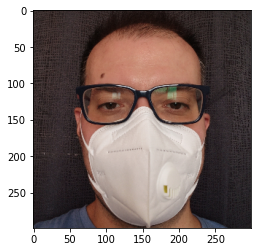

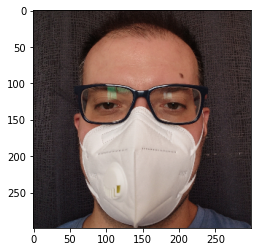

In [14]:
pos_class_idx = (y_binary==1).nonzero(as_tuple=True)[0]
pos_class_arrays = im_arrays[pos_class_idx]
pos_class_flipped_arrays = torch.flip(pos_class_arrays, dims=(2,))

show_image(pos_class_arrays[0])
show_image(pos_class_flipped_arrays[0])

In [16]:
#combine
pos_class_arrays = torch.cat((pos_class_arrays, pos_class_flipped_arrays), 0)
pos_class_arrays.size()

torch.Size([304, 3, 299, 299])

In [17]:
#get negative classes, shuffle, choose number equal to positive class
neg_class_idx = (y_binary==0).nonzero(as_tuple=True)[0]
neg_class_arrays = im_arrays[neg_class_idx]
idx = torch.randperm(neg_class_arrays.size(0))
neg_class_arrays = neg_class_arrays[idx]
neg_class_arrays = neg_class_arrays[:pos_class_arrays.size(0)]
neg_class_arrays.size()

torch.Size([304, 3, 299, 299])

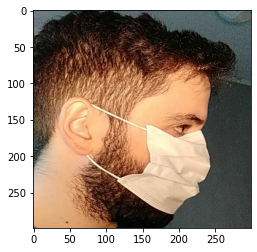

In [18]:
show_image(neg_class_arrays[0])

In [19]:
#combine and shuffle
im_tensors = torch.cat((pos_class_arrays, neg_class_arrays), 0)

#create y_binary
y_binary = torch.tensor([1]*pos_class_arrays.size(0) + [0]*neg_class_arrays.size(0))

idx = torch.randperm(im_tensors.size(0))
im_tensors = im_tensors[idx]
y_binary = y_binary[idx]

im_tensors.size()

torch.Size([608, 3, 299, 299])

In [20]:
#verify they are correct

pos_class_idx = (y_binary==1).nonzero(as_tuple=True)[0]
pos_class_idx[0]

tensor(1)

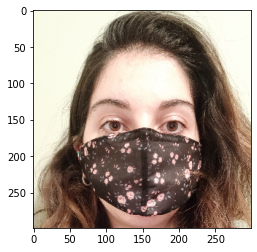

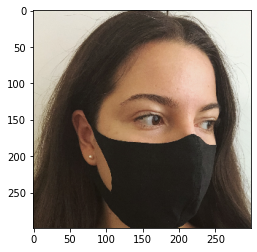

In [21]:
show_image(im_tensors[0])
show_image(im_tensors[1])

In [22]:
#split into train/cross validation/test
lab2idx = {'Not Worn Correctly':0, 'Worn Correctly':1}

x_test = im_tensors[:100]
y_test = y_binary[:100]

x_cv = im_tensors[100:150]
y_cv = y_binary[100:150]

x_train = im_tensors[150:]
y_train = y_binary[150:]

#### Train binary model on mask worn properly or not

In [31]:
#inception v3 has auxillary outputs we don't want
model = models.inception_v3(pretrained=True, aux_logits=False)
model.fc = nn.Linear(2048, 2)

In [32]:
# apply differential learning rates

optimizer = optim.AdamW([
    {'params': model.fc.parameters(), 'lr': 1e-3},
    {'params': model.Mixed_7c.parameters(), 'lr': 1e-4},
    {'params': model.Mixed_7b.parameters(), 'lr': 1e-4},
    {'params': model.Mixed_7a.parameters(), 'lr': 1e-5},
    {'params': model.Mixed_6e.parameters(), 'lr': 1e-5},
    {'params': model.Mixed_6d.parameters(), 'lr': 1e-5},
    {'params': model.Mixed_6c.parameters(), 'lr': 1e-6},
    {'params': model.Mixed_6b.parameters(), 'lr': 1e-6},
    {'params': model.Mixed_6a.parameters(), 'lr': 1e-6},
    {'params': model.Mixed_5d.parameters(), 'lr': 1e-7},
    {'params': model.Mixed_5c.parameters(), 'lr': 1e-7},
    {'params': model.Mixed_5b.parameters(), 'lr': 1e-7}
], lr=1e-8)

In [33]:
def finetune_model(model, optimizer, model_path, lab2idx, 
                   x_train, y_train, x_cv, y_cv, x_test, y_test,
                   device, batch_size=32, n_epochs=20):
    model.train()
    criterion = nn.CrossEntropyLoss()
    scheduler = ReduceLROnPlateau(optimizer, 'min', patience=10)
    train_losses = []
    cv_losses = []
    
    if not os.path.exists(model_path):
        os.mkdir(model_path)

    best_acc = 0
    
    for epoch in range(n_epochs):
        print('Epoch: %d' % epoch)
        
        idx = torch.randperm(x_train.size(0))
        x_train = x_train[idx]
        y_train = y_train[idx]
        
        ep_ttl = 0
   
        for j in range(0, x_train.size(0), batch_size):
            ep_ttl += 1
            x_batch = x_train[j:j+batch_size].to(device)
            y_batch = y_train[j:j+batch_size].to(device)

            #reset gradient for this iteration
            optimizer.zero_grad()

            #run the data through the model
            output = model(x_batch)

            #get the negative log likelihood loss
            loss = criterion(output, y_batch)

            #calculate the gradients
            loss.backward()

            #update the parameters from the gradients
            optimizer.step()

            if ep_ttl%50==0:
                print('Epoch: %d, Batch: %d, Loss: %.6f' % (epoch, j, loss.item()))
                train_losses.append(loss.item())

        ##### more testing, used to be at epoch level
        print('Testing model...')
        acc, cv_loss = test(model, criterion, x_cv, y_cv, lab2idx)
        scheduler.step(cv_loss)
        cv_losses.append(cv_loss)
        print('CV accuracy %.6f, prev best acc: %.6f %s' % (acc, best_acc, '!! IMPROVED !!' if acc>best_acc else ''))

        if acc>best_acc:
            best_acc = acc
            no_improvement = 0
            print('Saving model...')
            torch.save(model.state_dict(), '%s/model.pt' % model_path)
            torch.save(optimizer.state_dict(), '%s/optimizer.pt' % model_path)
        else:
            no_improvement += 1

        if no_improvement >= 50:
            print('no improvement in several epochs, breaking')
            break
            
    model.load_state_dict(torch.load('%s/model.pt' % model_path))
    test_acc, _ = test(model, criterion, x_test, y_test, lab2idx, True)
    print('final test accuracy: %.6f' % test_acc)
    model.eval()
    
    return model, train_losses, cv_losses

            
def test(model, criterion, x_test, y_test, lab2idx, print_report=False):
    model.eval()
    
    correct = 0
    loss = 0
    with torch.no_grad():
        output = model(x_test)
        
        loss = criterion(output, y_test)
        
        #select the indices of the maximum output values/prediction
        _, y_pred = torch.max(output, 1)

        #compare them with the target digits and sum correct predictions
        correct = y_pred.eq(y_test).sum()
        
    acc = correct / y_test.size()[0]
    
    print('Test accuracy %.6f, %d of %d' % (acc, correct, y_test.size(0)))
    
    if print_report:
        idx2lab = {v:k for k,v in lab2idx.items()}
        class_labels = [idx2lab[i] for i in range(len(idx2lab))]
        
        print('\n\n')
        print(classification_report(y_test.tolist(), y_pred.tolist(), target_names=class_labels, digits=4))
        print('\n\n')
    
        cm = confusion_matrix(y_test.tolist(), y_pred.tolist())
        fig, ax = plt.subplots(figsize=(12,10))
        f = sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, ax=ax)
    
    model.train()
    
    return acc, loss.item()

Epoch: 0
Epoch: 0, Batch: 392, Loss: 0.415450
Testing model...
Test accuracy 0.700000, 35 of 50
CV accuracy 0.700000, prev best acc: 0.000000 !! IMPROVED !!
Saving model...
Epoch: 1
Epoch: 1, Batch: 392, Loss: 0.044946
Testing model...
Test accuracy 0.780000, 39 of 50
CV accuracy 0.780000, prev best acc: 0.700000 !! IMPROVED !!
Saving model...
Epoch: 2
Epoch: 2, Batch: 392, Loss: 0.051420
Testing model...
Test accuracy 0.780000, 39 of 50
CV accuracy 0.780000, prev best acc: 0.780000 
Epoch: 3
Epoch: 3, Batch: 392, Loss: 0.022439
Testing model...
Test accuracy 0.760000, 38 of 50
CV accuracy 0.760000, prev best acc: 0.780000 
Epoch: 4
Epoch: 4, Batch: 392, Loss: 0.053512
Testing model...
Test accuracy 0.840000, 42 of 50
CV accuracy 0.840000, prev best acc: 0.780000 !! IMPROVED !!
Saving model...
Epoch: 5
Epoch: 5, Batch: 392, Loss: 0.002142
Testing model...
Test accuracy 0.820000, 41 of 50
CV accuracy 0.820000, prev best acc: 0.840000 
Epoch: 6
Epoch: 6, Batch: 392, Loss: 0.007159
Testin

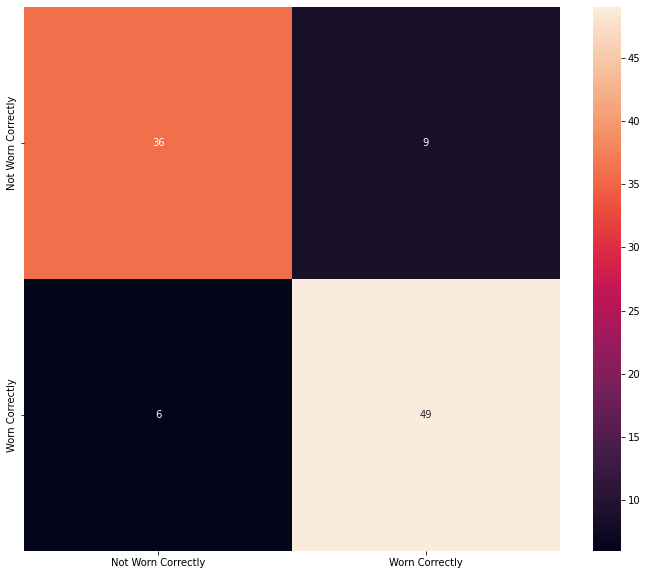

In [34]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model_path = 'inceptionv3_model'

model, train_losses, cv_losses = finetune_model(model, optimizer, model_path, lab2idx,
                                                x_train, y_train, x_cv, y_cv, x_test, y_test,
                                                device, batch_size=8, n_epochs=50)

In [35]:
model.load_state_dict(torch.load('%s/model.pt' % model_path))

<All keys matched successfully>

Test accuracy 0.850000, 85 of 100



                    precision    recall  f1-score   support

Not Worn Correctly     0.8571    0.8000    0.8276        45
    Worn Correctly     0.8448    0.8909    0.8673        55

          accuracy                         0.8500       100
         macro avg     0.8510    0.8455    0.8474       100
      weighted avg     0.8504    0.8500    0.8494       100






(tensor(0.8500), 0.4621315002441406)

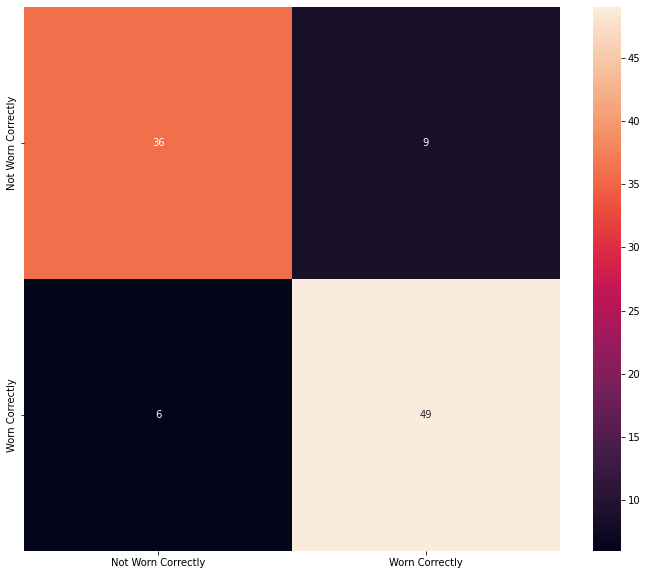

In [36]:
criterion = nn.CrossEntropyLoss()
test(model, criterion, x_test, y_test, lab2idx, print_report=True)

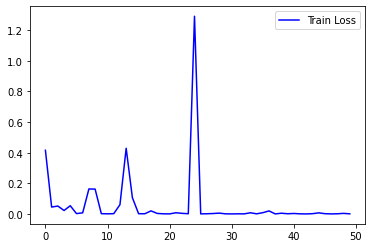

In [37]:
fig = plt.figure()
plt.plot(train_losses, color='blue')
plt.legend(['Train Loss'], loc='upper right')

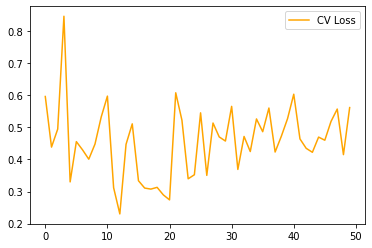

In [38]:
fig = plt.figure()
plt.plot(cv_losses, color='orange')

plt.legend(['CV Loss'], loc='upper right')